# Utilities

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
import matplotlib.lines as mlines
import optuna
import os
import pywt


optuna.logging.set_verbosity(optuna.logging.WARNING)

In [238]:
def read_files(filenames: list):
    """
    Read a list of files and return a single dataframe
    
    Parameters:
    -----------
    filenames : list
        List of filenames to read
    
    Returns:
    --------
    pd.DataFrame
    """
    return pd.concat([pd.read_csv(f'./data/{filename}') for filename in filenames])


def read_all_files():
    """
    Read all files in the data directory and return a single dataframe
    
    Returns:
    --------
    pd.DataFrame
    """

    dir = os.listdir('./data/')

    filenames = [filename for filename in dir if filename.endswith('.csv')]
    
    return read_files(filenames)

def categorize_port(port):
    if port in [80, 443, 444, 8080, 8443]:  # Common web ports
        return 'web'
    elif port in [22, 23, 21]:  # SSH, Telnet, FTP
        return 'remote_access'
    elif port in [53]:  # DNS
        return 'dns'
    elif port in range(10, 1024):  # Well-known ports
        return 'well_known'
    elif port in range(1024, 49151):  # Registered ports
        return 'registered'
    elif port >= 49152:  # Dynamic/private ports
        return 'dynamic'
    else:
        return 'unknown'  # Other/unknown ports

In [767]:
class Data:
    def __init__(self, df, prepare_index = False):
        if prepare_index:
            df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed')
            df = df.set_index('timestamp')
            df = df.sort_index()
        
        self.df = df

    def assign(self, **kwargs):
        return Data(self.df.assign(**kwargs))
    
    def benign(self):
        return self.with_label('Benign')

    def with_label(self, label):
        return Data(self.df[self.df['label'] == label])
    
    def with_date(self, date):
        return Data(self.df.loc[date])
    
    def internal_dst(self):
        return Data(self.df[self.df['dst_ip'].str.contains('192.168')])
    
    def internal_src(self):
        return Data(self.df[self.df['src_ip'].str.contains('192.168')])
    
    def get_dummies(self, columns, dtype = int, drop_first = False):
        return Data(pd.get_dummies(self.df, columns = columns, dtype=dtype, drop_first=drop_first))
    
    def pca_numeric(self, n_components):
        X = self.df.select_dtypes(include=[np.number])
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)

        print(f'Explained variance: {np.sum(pca.explained_variance_ratio_):.2%}')
        # return Data(pd.DataFrame(X_pca, index = X.index, columns=[f'pca_{i}' for i in range(n_components)]))

        result_df = pd.DataFrame(X_pca, index = X.index, columns=[f'pca_{i}' for i in range(n_components)])
        label = self.df['label']
        return Data(pd.concat([result_df, label], axis=1))
    
    def resample(self, resampler):
        return Data(resampler.resample(self))
    
    def X_y(self, y_column):
        return self.df.drop(columns = y_column), self.df[y_column]
    
    def show(self):
        display(self.df)

class Resampler:
    def __init__(self, agg, interval = '1s', interpolate = 'zero'):
        self.agg = agg
        self.interval = interval
        self.interpolate = interpolate
    
    def resample(self, data):
        return data.df.resample(self.interval).agg(self.agg).interpolate(self.interpolate)

def plot_predictions(y_true, y_pred, swt_df):
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Plot each SWT column with its label
    for col in swt_df.columns:
        ax.plot(swt_df.index, swt_df[col], label=col)
    
    # Plot axvlines based on your conditions
    for i in swt_df[y_pred == -1].index:
        if i not in y_true[y_true == -1].index:
            ax.axvline(i, 0, 1, color='y', linestyle='dashed', linewidth=0.3, alpha=0.3)
        else:
            ax.axvline(i, 0, 1, color='g', linestyle='dashed', linewidth=0.3, alpha=0.3)
    
    for i in y_true[y_true == -1].index:
        if i not in swt_df[y_pred == -1].index:
            ax.axvline(i, 0, 1, color='r', linestyle='dashed', linewidth=0.3, alpha=0.3)
    
    legend1 = ax.legend(loc='upper left', title="Columns")
    ax.add_artist(legend1) 
    
    yellow_line = mlines.Line2D([], [], color='y', linestyle='dashed', linewidth=1,
                                  label='Yellow: Predicted anomaly only')
    green_line = mlines.Line2D([], [], color='g', linestyle='dashed', linewidth=1,
                                 label='Green: Predicted & True anomaly')
    red_line = mlines.Line2D([], [], color='r', linestyle='dashed', linewidth=1,
                               label='Red: True anomaly only')
    
    legend2 = ax.legend(handles=[yellow_line, green_line, red_line],
                        loc='upper left', bbox_to_anchor=(0, 0.15), title="Predictions")
    
    ax.set_title("Predictions displayed on the SWT coefficients data")
    ax.set_xlabel("Time (sec)")
    ax.set_ylabel("SWT Coefficients")
    plt.show()


# Load the data

In [746]:
df = read_all_files()

# Intrusion Detection

## Preprocess the data

In [942]:
TRAIN_DAY = '2017-07-03'
TEST_DAY = '2017-07-07'

In [943]:
data = Data(df, prepare_index=True)

In [944]:
internal = data.internal_dst().assign(
    dst_host_port = lambda x: x['dst_ip'] + ":" + x['dst_port'].astype(str),
    dst_port_category=lambda x: x['dst_port'].apply(categorize_port),
    src_port_category=lambda x: x['src_port'].apply(categorize_port)
).get_dummies(['dst_port_category', 'src_port_category'])
internal.show()

,flow_id,src_ip,src_port,dst_ip,dst_port,protocol,duration,packets_count,fwd_packets_count,bwd_packets_count,...,dst_port_category_unknown,dst_port_category_web,dst_port_category_well_known,src_port_category_dns,src_port_category_dynamic,src_port_category_registered,src_port_category_remote_access,src_port_category_unknown,src_port_category_web,src_port_category_well_known
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-07-03 07:55:58.598308,8.254.250.126_80_192.168.10.5_49188_TCP_2017-0...,8.254.250.126,80,192.168.10.5,49188,TCP,0.000010,8,8,0,...,0,0,0,0,0,0,0,0,1,0
2017-07-03 07:56:22.331018,8.253.185.121_80_192.168.10.14_49486_TCP_2017-...,8.253.185.121,80,192.168.10.14,49486,TCP,0.000010,9,9,0,...,0,0,0,0,0,0,0,0,1,0
2017-07-03 07:56:37.897192,192.168.10.9_137_192.168.10.3_137_UDP_2017-07-...,192.168.10.9,137,192.168.10.3,137,UDP,83.068408,80,38,42,...,0,0,1,0,0,0,0,0,0,1
2017-07-03 07:56:37.908429,192.168.10.9_63683_192.168.10.3_53_UDP_2017-07...,192.168.10.9,63683,192.168.10.3,53,UDP,0.000292,4,2,2,...,0,0,0,0,1,0,0,0,0,0
2017-07-03 07:56:37.908639,192.168.10.9_63276_192.168.10.3_53_UDP_2017-07...,192.168.10.9,63276,192.168.10.3,53,UDP,0.000293,4,2,2,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-07 16:02:38.913542,192.168.10.8_123_192.168.10.3_123_UDP_2017-07-...,192.168.10.8,123,192.168.10.3,123,UDP,0.000125,4,2,2,...,0,0,1,0,0,0,0,0,0,1
2017-07-07 16:02:39.565876,192.168.10.50_22_192.168.10.17_37758_TCP_2017-...,192.168.10.50,22,192.168.10.17,37758,TCP,0.000085,3,0,3,...,0,0,0,0,0,0,1,0,0,0
2017-07-07 16:02:39.567285,192.168.10.17_37759_192.168.10.50_22_TCP_2017-...,192.168.10.17,37759,192.168.10.50,22,TCP,1.238502,85,42,43,...,0,0,0,0,0,1,0,0,0,0


In [945]:
resampler = Resampler({
    "payload_bytes_std": lambda x: np.log(1 / (np.mean(x) + 1)),
    "dst_port_category_web": "sum",
    "rst_flag_counts": "sum",
    "dst_host_port": "nunique",
    "label": lambda x: 1 if x.eq("Benign").all() else -1
}, '1s')

monday = internal.with_date(TRAIN_DAY).with_label('Benign').resample(resampler)
friday = internal.with_date(TEST_DAY).resample(resampler)

monday.show()
friday.show()

,payload_bytes_std,dst_port_category_web,rst_flag_counts,dst_host_port,label
timestamp,,,,,
2017-07-03 07:55:58,0.000000,0,0,1,1
2017-07-03 07:55:59,0.000000,0,0,0,1
2017-07-03 07:56:00,0.000000,0,0,0,1
2017-07-03 07:56:01,0.000000,0,0,0,1
2017-07-03 07:56:02,0.000000,0,0,0,1
...,...,...,...,...,...
2017-07-03 16:01:30,0.000000,0,0,3,1
2017-07-03 16:01:31,0.000000,0,0,0,1
2017-07-03 16:01:32,0.000000,0,0,0,1


,payload_bytes_std,dst_port_category_web,rst_flag_counts,dst_host_port,label
timestamp,,,,,
2017-07-07 07:59:50,-5.188826,0,2,2,1
2017-07-07 07:59:51,-5.188826,0,0,0,1
2017-07-07 07:59:52,-5.188826,0,0,0,1
2017-07-07 07:59:53,-5.188826,0,0,0,1
2017-07-07 07:59:54,-5.188826,0,0,0,1
...,...,...,...,...,...
2017-07-07 16:02:37,0.000000,0,0,1,1
2017-07-07 16:02:38,-4.468137,0,0,4,1
2017-07-07 16:02:39,-4.792003,0,0,2,1


In [946]:
# plt.hist(friday.df['duration'], bins=100)
# plt.show()

<Axes: >

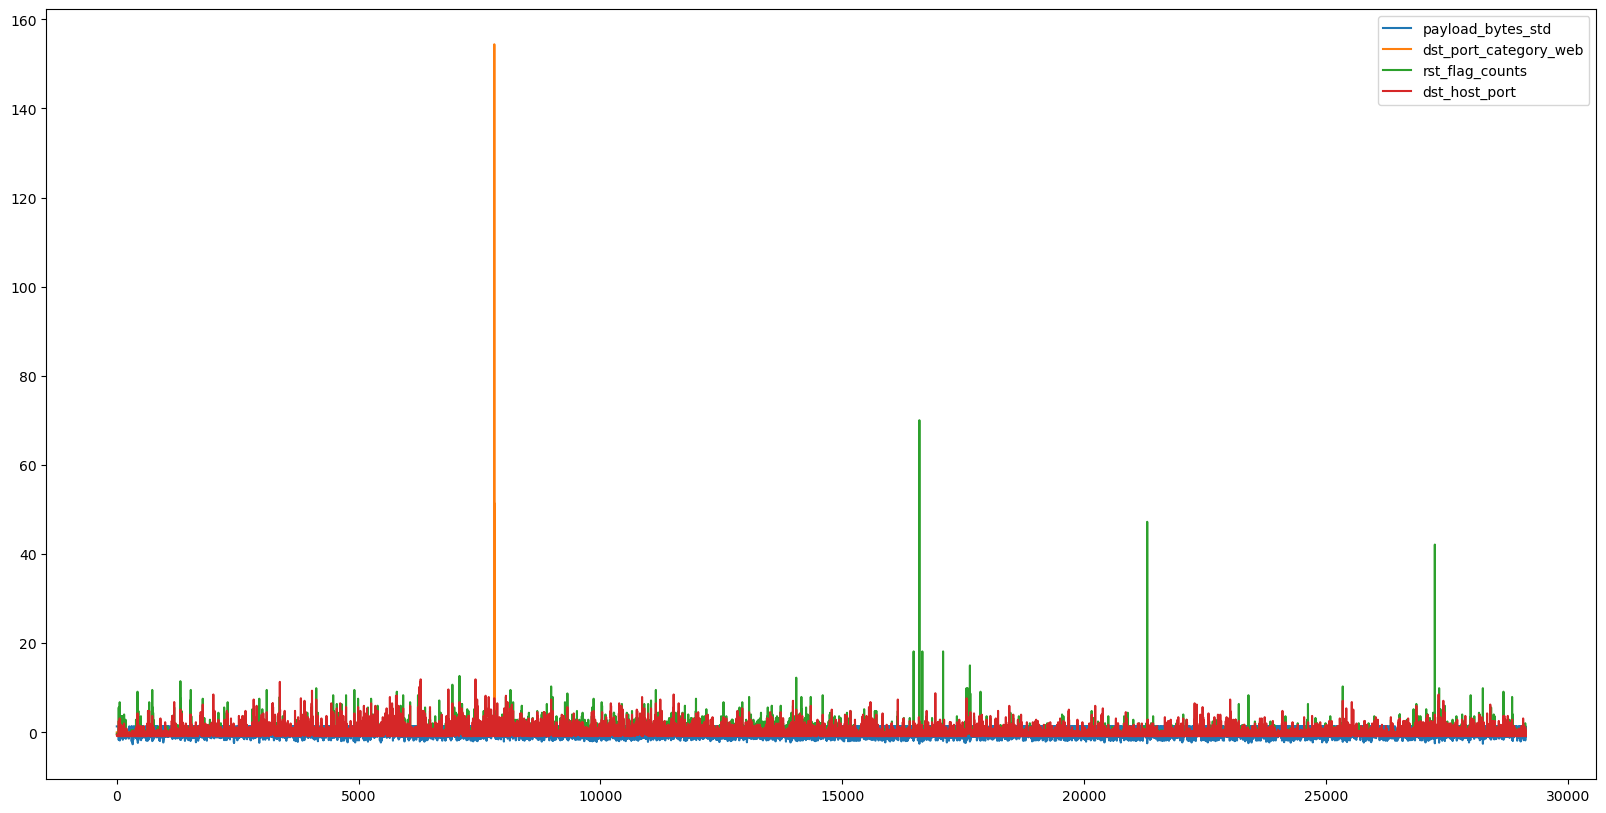

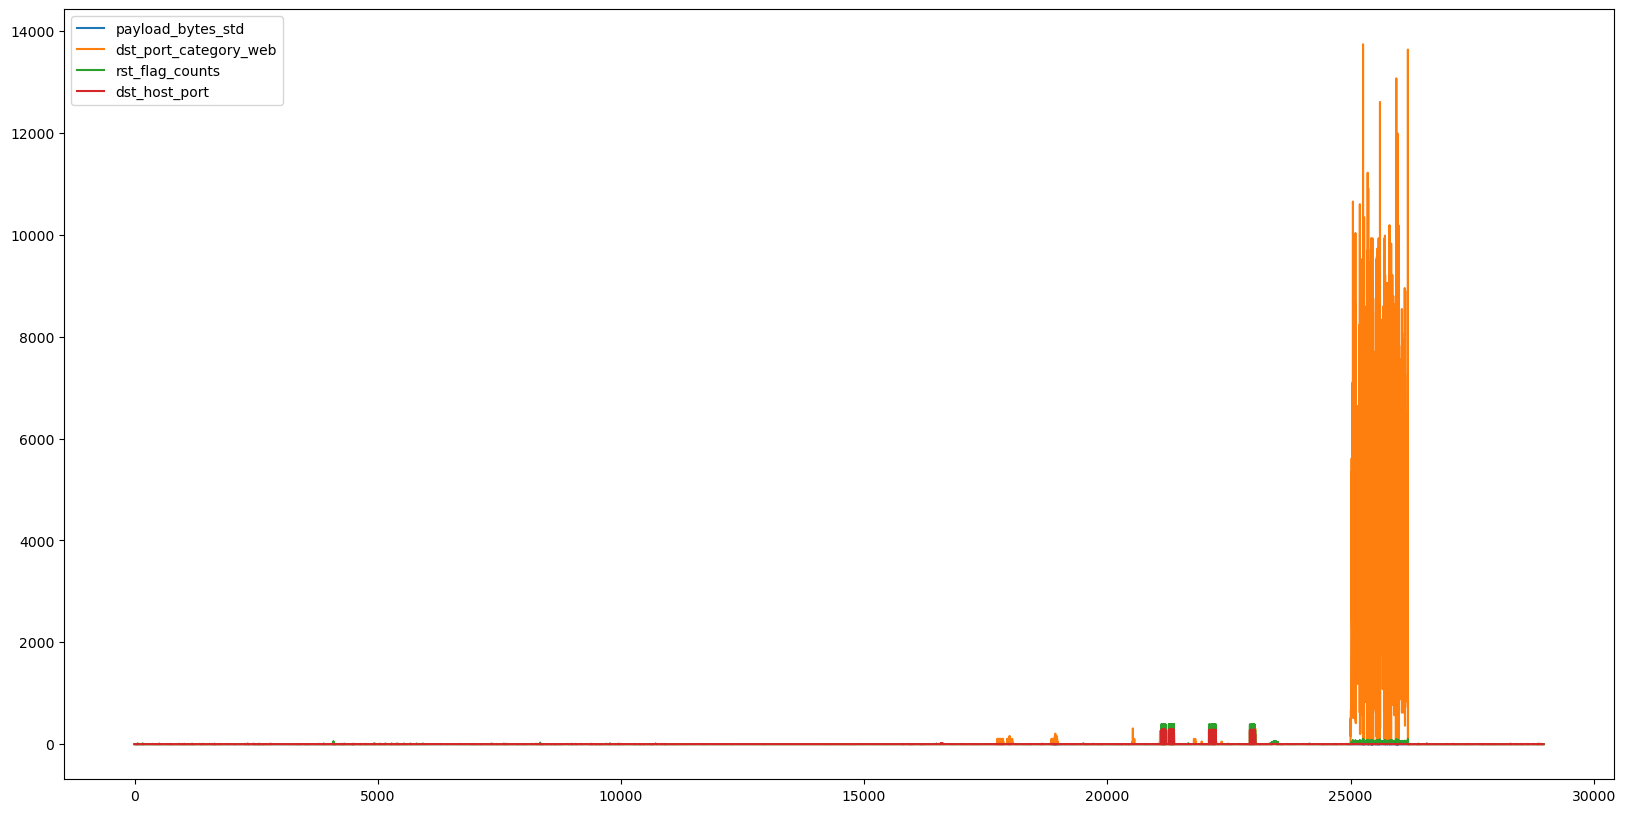

In [947]:
X_monday, y_monday = monday.X_y('label')
X_friday, y_friday = friday.X_y('label')

scaler = StandardScaler()
X_monday = pd.DataFrame(scaler.fit_transform(X_monday), columns=X_monday.columns)
X_friday = pd.DataFrame(scaler.transform(X_friday), columns=X_friday.columns)

X_monday.plot(figsize=(20, 10))
X_friday.plot(figsize=(20, 10))

## Friday (Isolation Forest no SWT)

  0%|          | 0/100 [00:00<?, ?it/s]

Best Parameters: {'contamination': 0.00785620231611959}
Best score: 0.788787483702738
              precision    recall  f1-score   support

     Anomaly       0.85      0.74      0.79      1641
      Normal       0.98      0.99      0.99     27331

    accuracy                           0.98     28972
   macro avg       0.92      0.86      0.89     28972
weighted avg       0.98      0.98      0.98     28972



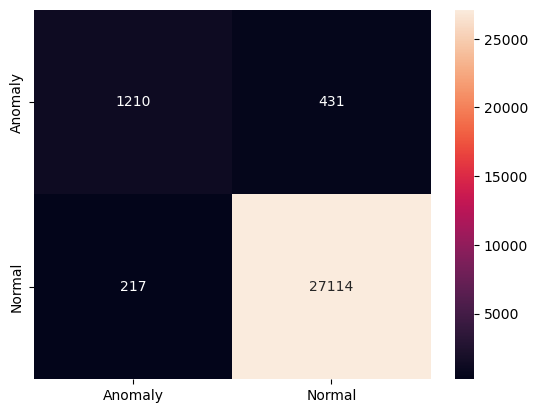

In [948]:

y_true = y_friday.reset_index(drop=True)

def objective(trial):
    c = trial.suggest_float("contamination", 0.001, 0.2)

    clf = IsolationForest(contamination=c, bootstrap=True, random_state=3123)
    clf.fit(X_monday)

    y_pred = clf.predict(X_friday)

    return f1_score(y_true, y_pred, average="binary", pos_label=-1)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, n_jobs=8, show_progress_bar=True)

print("Best Parameters:", study.best_params)
print("Best score:", study.best_value)

clf_no_swt = IsolationForest(contamination=study.best_params['contamination'], bootstrap=True, random_state=3123)

clf_no_swt.fit(X_monday)

y_pred = clf_no_swt.predict(X_friday)

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=['Anomaly', 'Normal'], yticklabels=['Anomaly', 'Normal'])
print(classification_report(y_true, y_pred, target_names=['Anomaly', 'Normal']))

## Apply SWT


Choosing wavelet: https://www.mathworks.com/help/wavelet/gs/choose-a-wavelet.html

In [996]:
WAVELET = 'coif1'
LEVEL = 2

def swt_transform(X, wavelet='haar', level=2):
    if X.shape[0] % 2 != 0:
        X = X.iloc[:-1]
    
    coefs = pywt.swt2(X, wavelet, level=level, trim_approx=True, norm=True)

    return pd.DataFrame(coefs[level][1], columns=X.columns + '_ad')

def plot_coefs(coefs):
    plt.figure(figsize=(20, 10))
    plt.plot(coefs)
    plt.legend(coefs.columns)
    plt.show()

X_monday_swt = swt_transform(X_monday, WAVELET, level=LEVEL)
X_friday_swt = swt_transform(X_friday, WAVELET, level=LEVEL)

<Axes: >

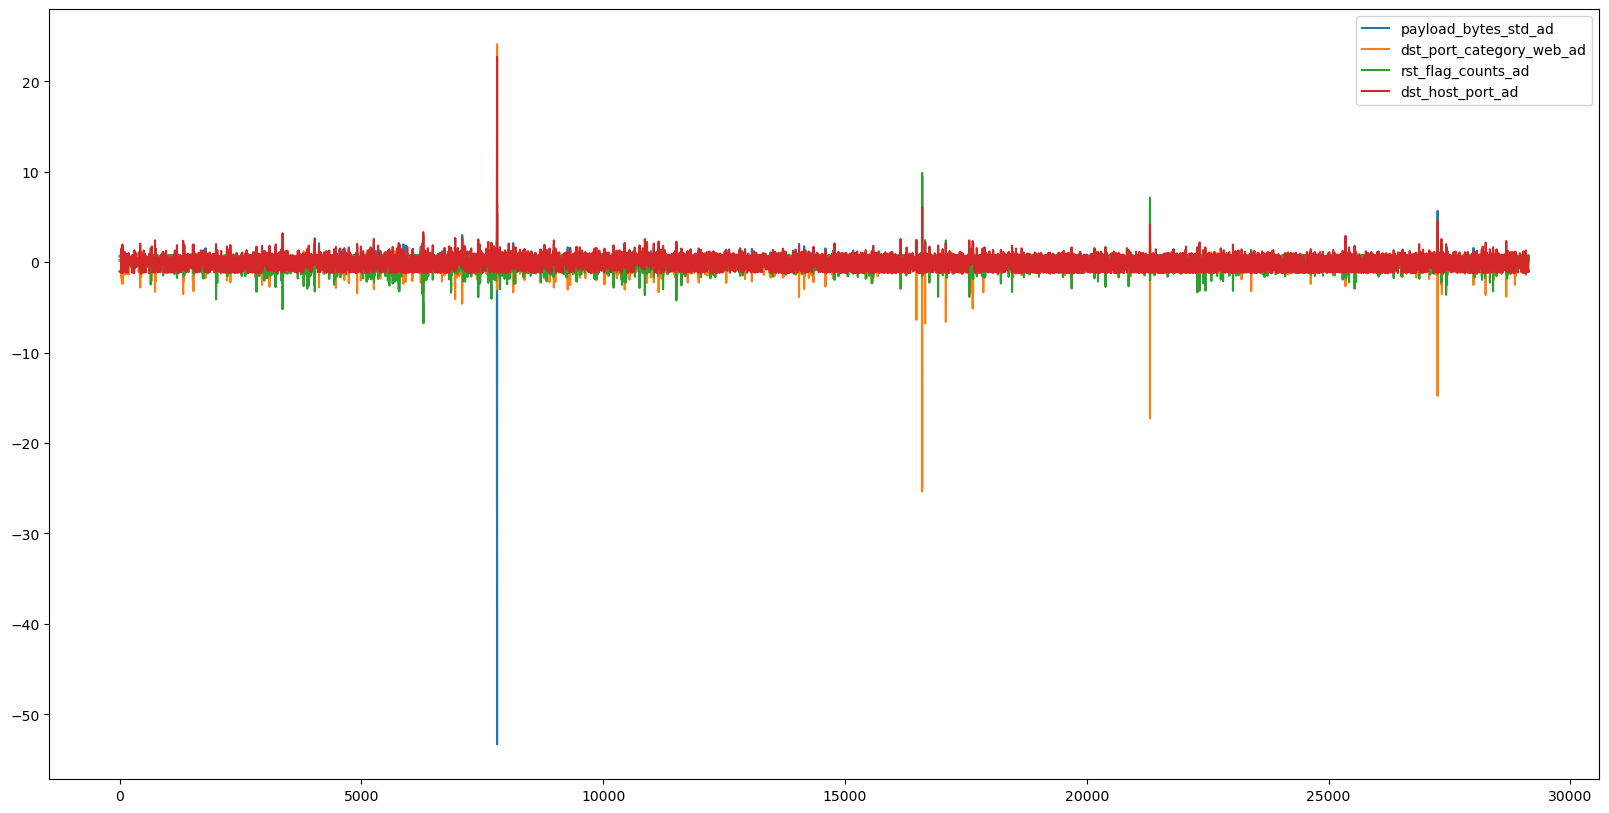

In [997]:
X_monday_swt.plot(figsize=(20, 10))

<Axes: >

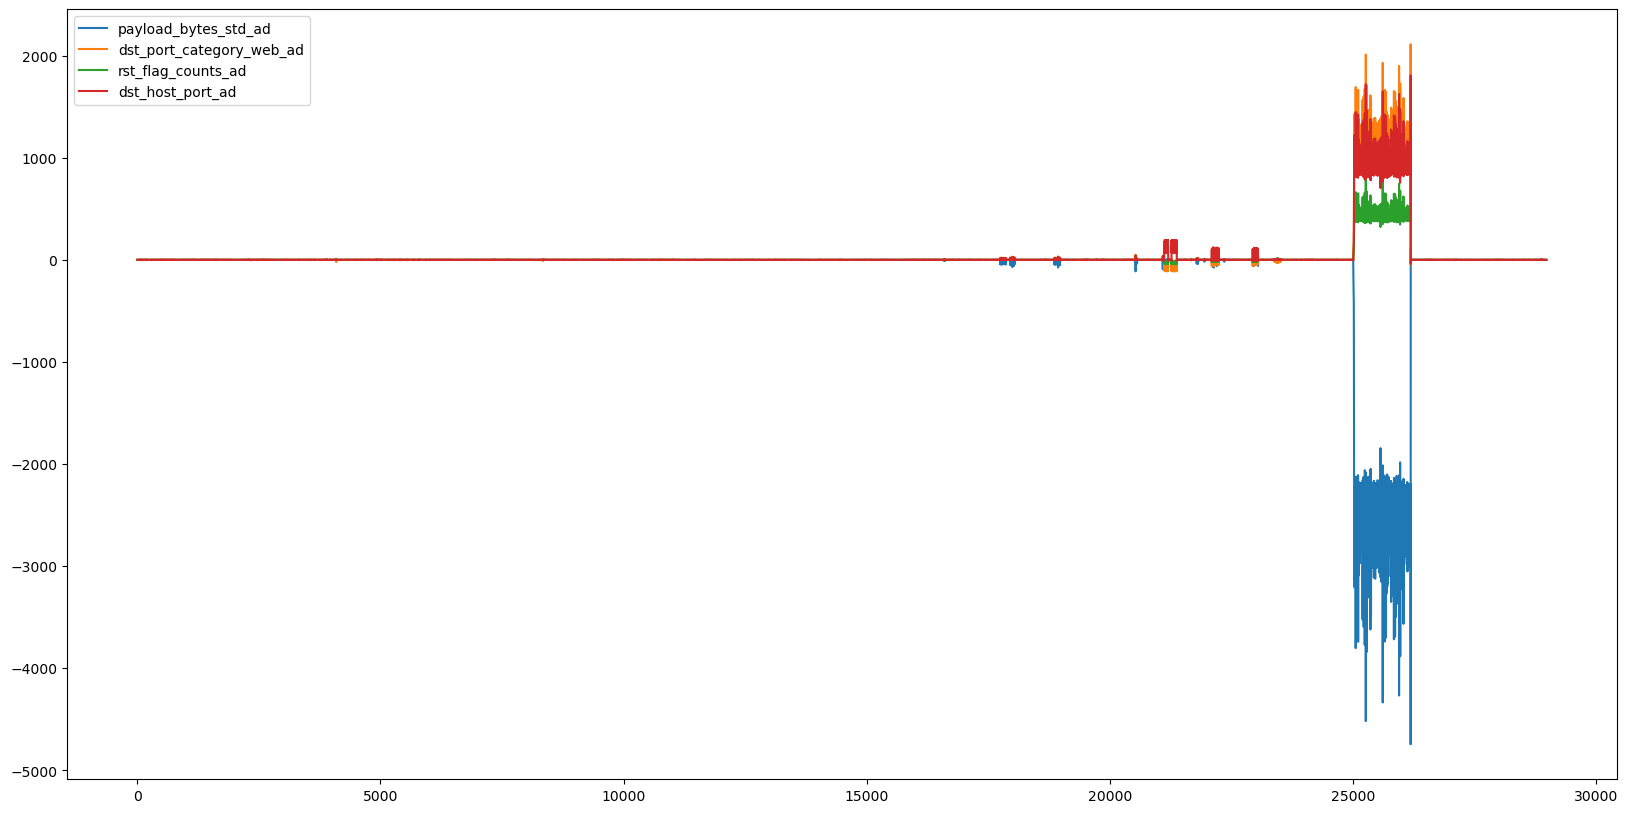

In [998]:
X_friday_swt.plot(figsize=(20, 10))

## Friday (Isolation forest with SWT)

  0%|          | 0/100 [00:00<?, ?it/s]

Best Parameters: {'contamination': 0.0035061001015641267}
best score: 0.8289587539659649
              precision    recall  f1-score   support

     Anomaly       0.79      0.88      0.83      1641
      Normal       0.99      0.99      0.99     27331

    accuracy                           0.98     28972
   macro avg       0.89      0.93      0.91     28972
weighted avg       0.98      0.98      0.98     28972



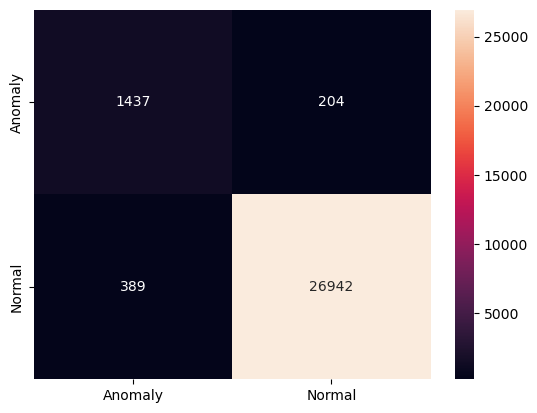

In [999]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
import optuna

y_true = y_friday.reset_index(drop=True)

def objective(trial):
    c = trial.suggest_float("contamination", 0.001, 0.2)  # Contamination

    clf = IsolationForest(contamination=c, bootstrap=True, random_state=3123)
    clf.fit(X_monday_swt)

    y_pred = clf.predict(X_friday_swt)

    return f1_score(y_true, y_pred, average="binary", pos_label=-1)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, n_jobs=8, show_progress_bar=True)

print("Best Parameters:", study.best_params)
print("best score:", study.best_value)

clf = IsolationForest(contamination=study.best_params['contamination'], bootstrap=True, random_state=3123)

clf.fit(X_monday_swt)

y_pred = clf.predict(X_friday_swt)

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=['Anomaly', 'Normal'], yticklabels=['Anomaly', 'Normal'])
print(classification_report(y_true, y_pred, target_names=['Anomaly', 'Normal']))

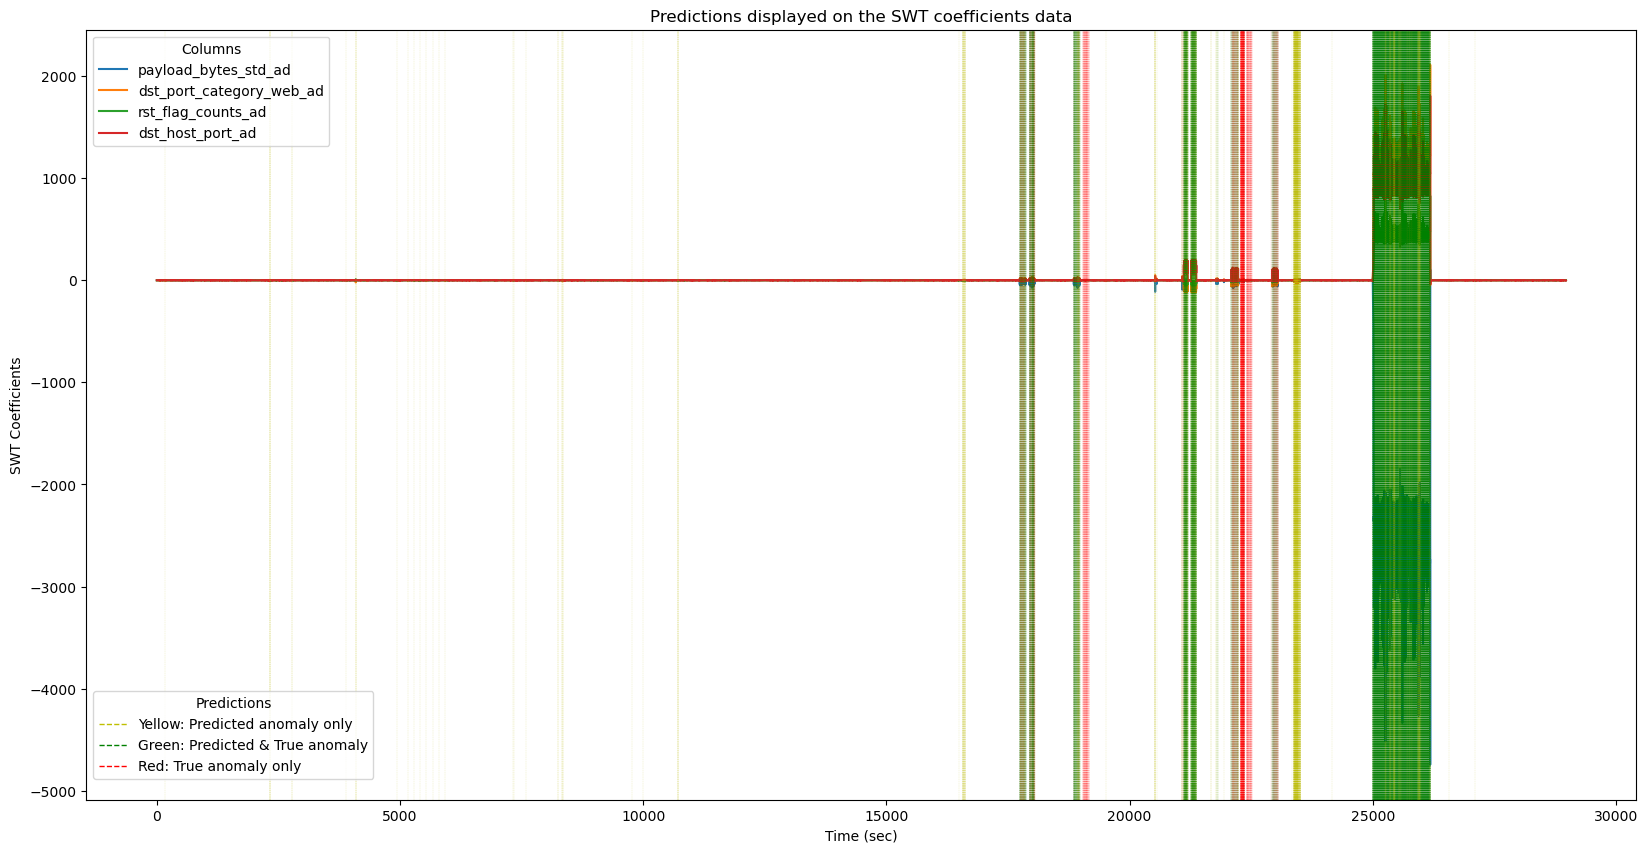

In [1000]:



plot_predictions(y_true, y_pred, X_friday_swt)

## Wednesday (Isolation Forest no SWT)

              precision    recall  f1-score   support

     Anomaly       0.77      0.16      0.26      2622
      Normal       0.93      1.00      0.96     27831

    accuracy                           0.92     30453
   macro avg       0.85      0.58      0.61     30453
weighted avg       0.91      0.92      0.90     30453



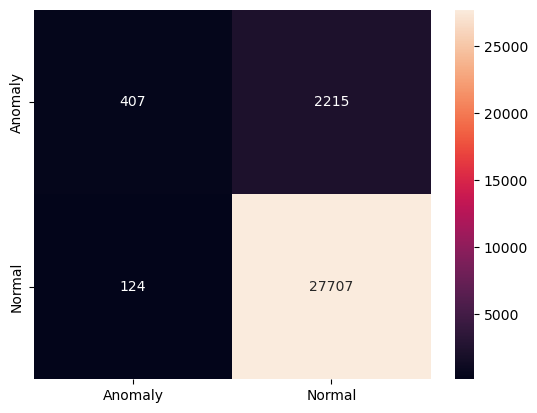

In [1001]:
wednesday = internal.with_date('2017-07-05').resample(resampler)

X_wednesday, y_wednesday = wednesday.X_y('label')

X_wednesday = pd.DataFrame(scaler.transform(X_wednesday), columns=X_wednesday.columns)

y_true = y_wednesday.reset_index(drop=True)

y_pred = clf_no_swt.predict(X_wednesday)

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=['Anomaly', 'Normal'], yticklabels=['Anomaly', 'Normal'])
print(classification_report(y_true, y_pred, target_names=['Anomaly', 'Normal']))

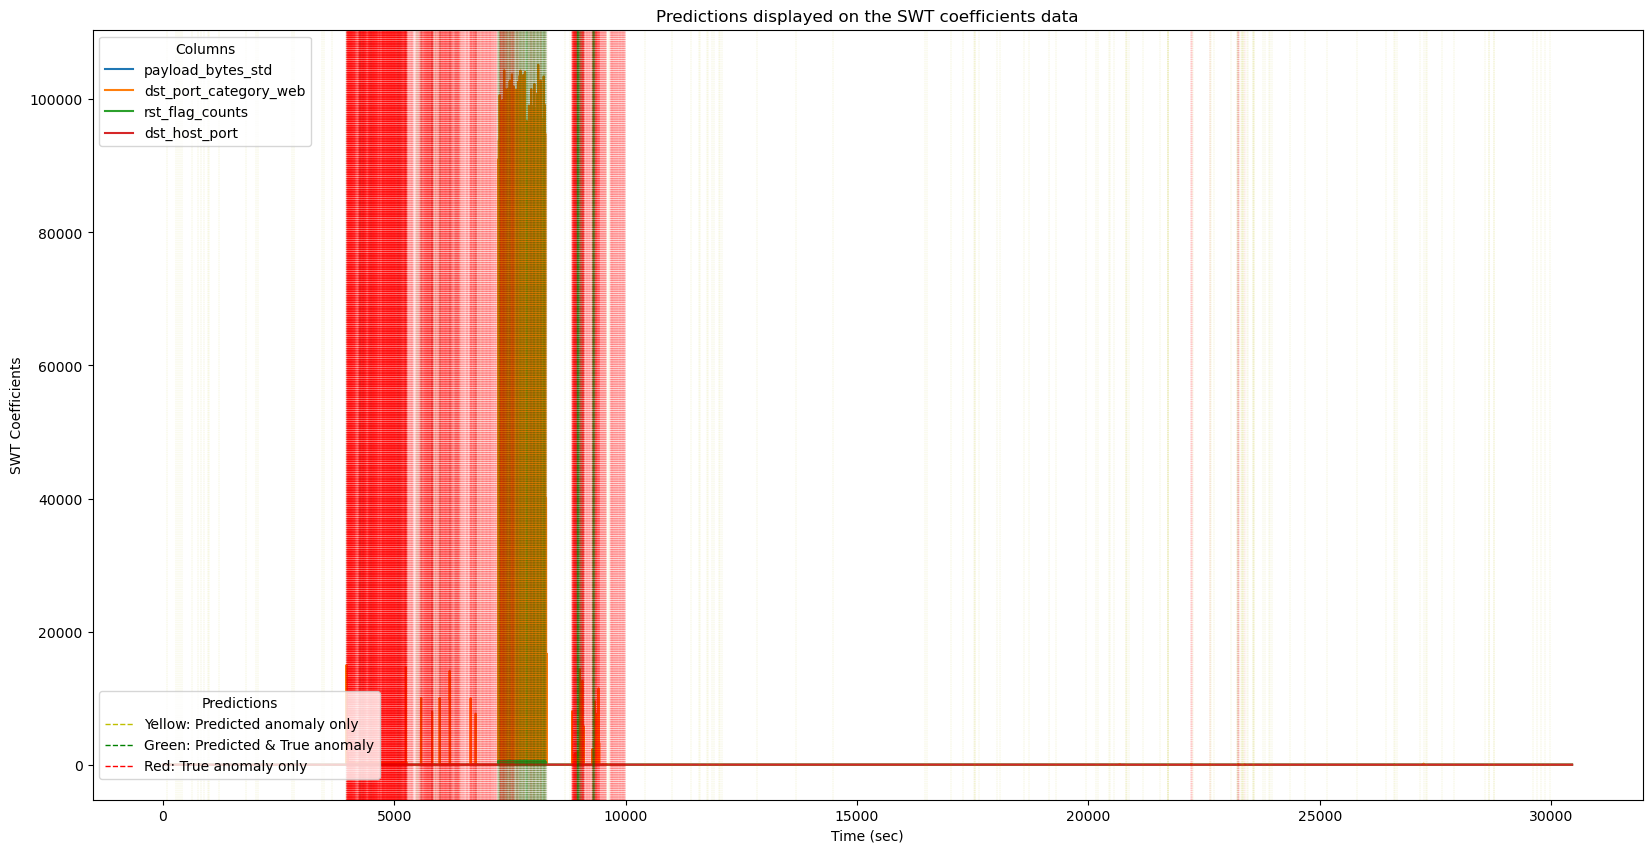

In [1002]:
plot_predictions(y_true, y_pred, X_wednesday)

## Wednesday (Isolation Forest with SWT)

              precision    recall  f1-score   support

     Anomaly       0.77      0.80      0.79      2622
      Normal       0.98      0.98      0.98     27830

    accuracy                           0.96     30452
   macro avg       0.88      0.89      0.88     30452
weighted avg       0.96      0.96      0.96     30452



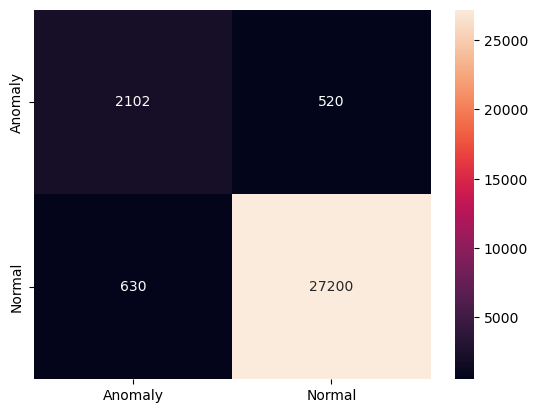

In [1003]:
X_wednesday_swt = swt_transform(X_wednesday, WAVELET, level=LEVEL)

y_true = y_wednesday.reset_index(drop=True)

y_pred = clf.predict(X_wednesday_swt)

sns.heatmap(confusion_matrix(y_true[:-1], y_pred), annot=True, fmt='d', xticklabels=['Anomaly', 'Normal'], yticklabels=['Anomaly', 'Normal'])
print(classification_report(y_true[:-1], y_pred, target_names=['Anomaly', 'Normal']))

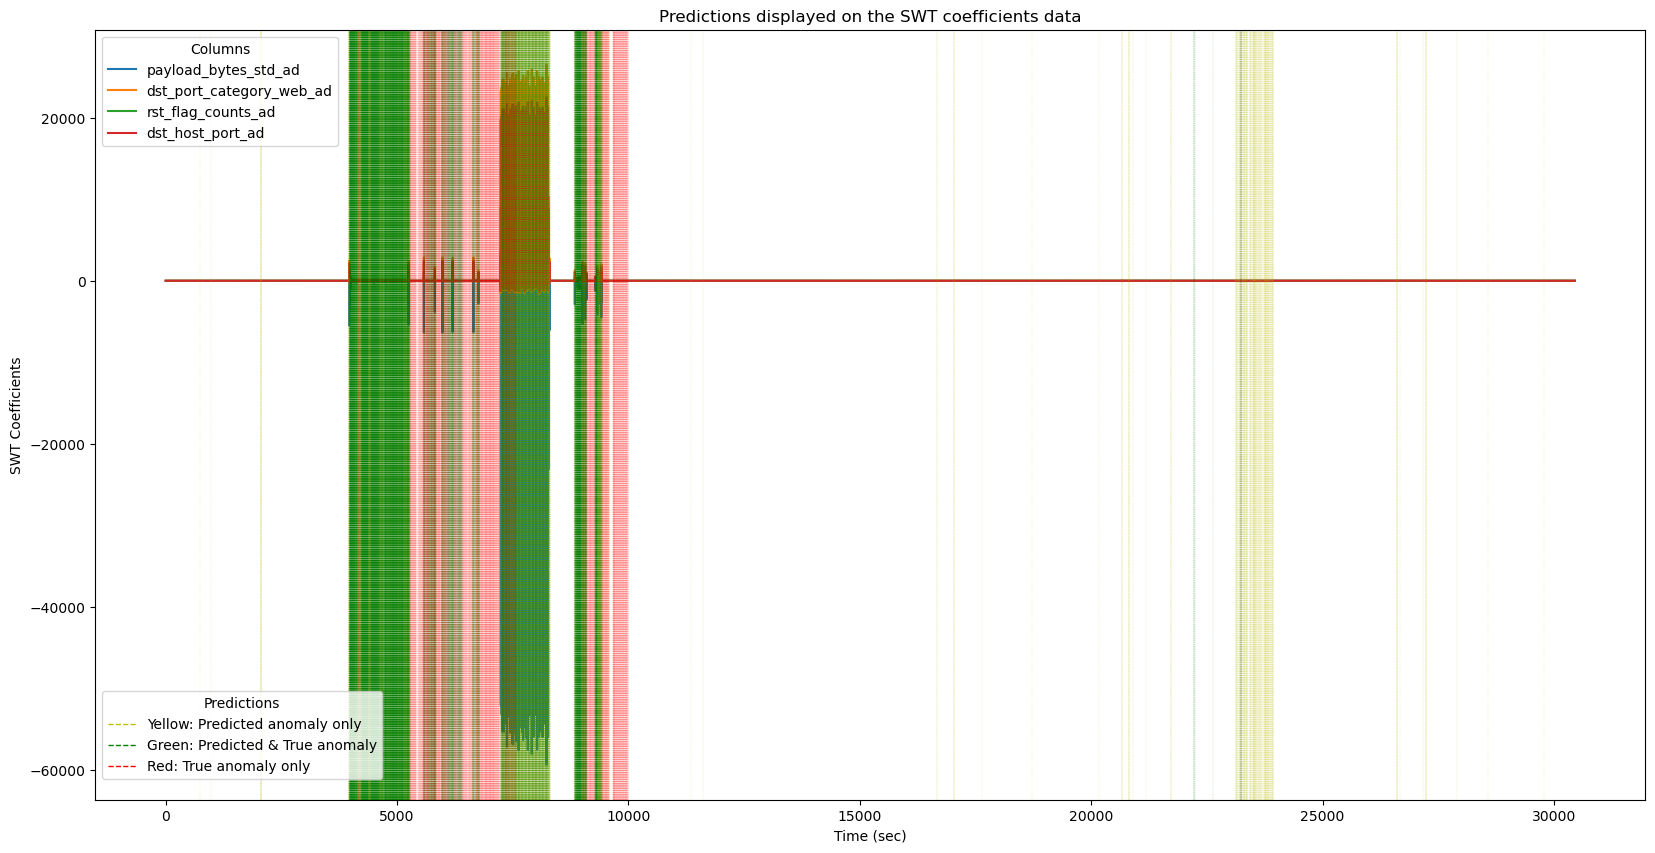

In [1004]:
plot_predictions(y_true[:-1], y_pred, X_wednesday_swt)

## Thursday (Isolation Forest without SWT)

              precision    recall  f1-score   support

     Anomaly       0.34      0.00      0.01      2682
      Normal       0.75      1.00      0.86      8178

    accuracy                           0.75     10860
   macro avg       0.55      0.50      0.43     10860
weighted avg       0.65      0.75      0.65     10860



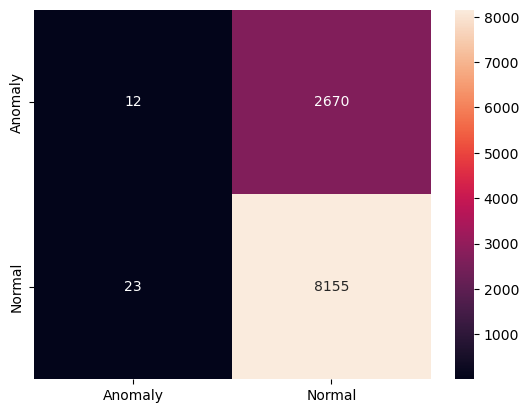

In [1005]:
thursday = internal.with_date('2017-07-06').resample(resampler)

X_thursday, y_thursday = thursday.X_y('label')

y_true = y_thursday.reset_index(drop=True)

X_thursday = pd.DataFrame(scaler.transform(X_thursday), columns=X_thursday.columns)

y_pred = clf_no_swt.predict(X_thursday)

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=['Anomaly', 'Normal'], yticklabels=['Anomaly', 'Normal'])
print(classification_report(y_true, y_pred, target_names=['Anomaly', 'Normal']))

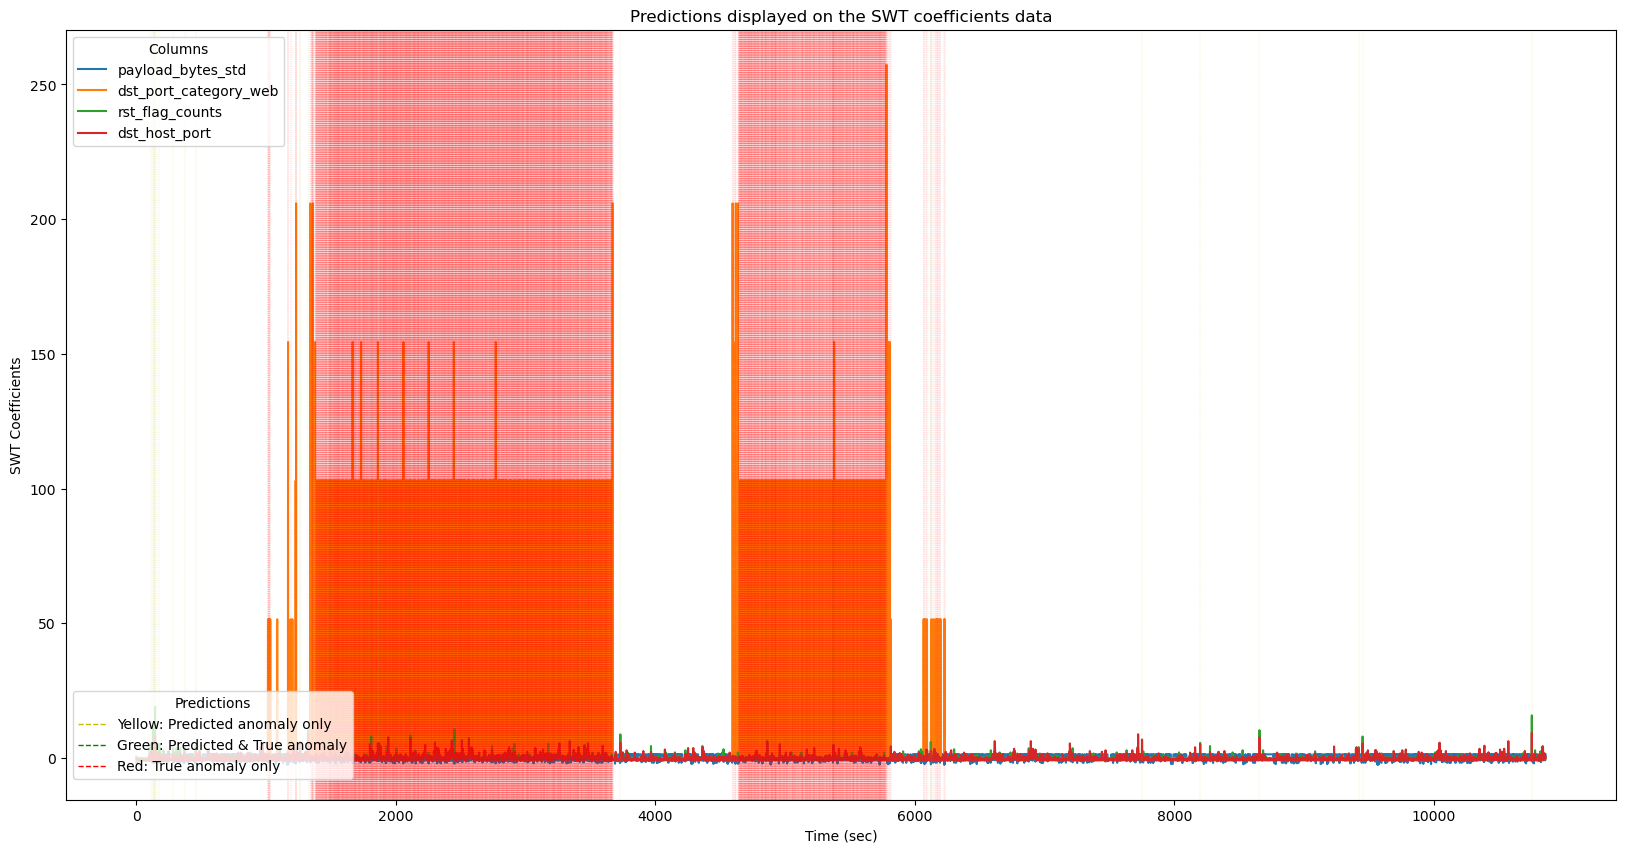

In [1006]:
plot_predictions(y_true, y_pred, X_thursday)

## Thursday (Isolation Forest with SWT)

              precision    recall  f1-score   support

     Anomaly       0.90      1.00      0.95      2682
      Normal       1.00      0.96      0.98      8178

    accuracy                           0.97     10860
   macro avg       0.95      0.98      0.96     10860
weighted avg       0.97      0.97      0.97     10860



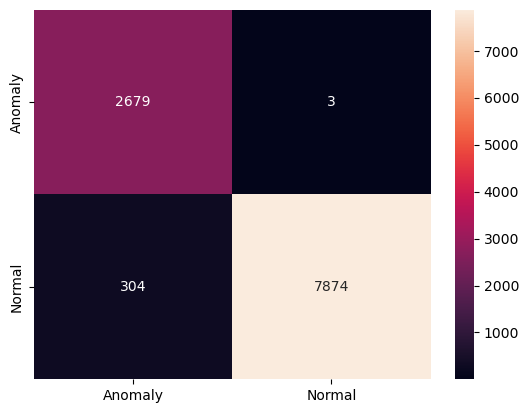

In [1007]:
X_thursday_swt = swt_transform(X_thursday, WAVELET, level=LEVEL)

y_true = y_thursday.reset_index(drop=True)

y_pred = clf.predict(X_thursday_swt)

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=['Anomaly', 'Normal'], yticklabels=['Anomaly', 'Normal'])
print(classification_report(y_true, y_pred, target_names=['Anomaly', 'Normal']))

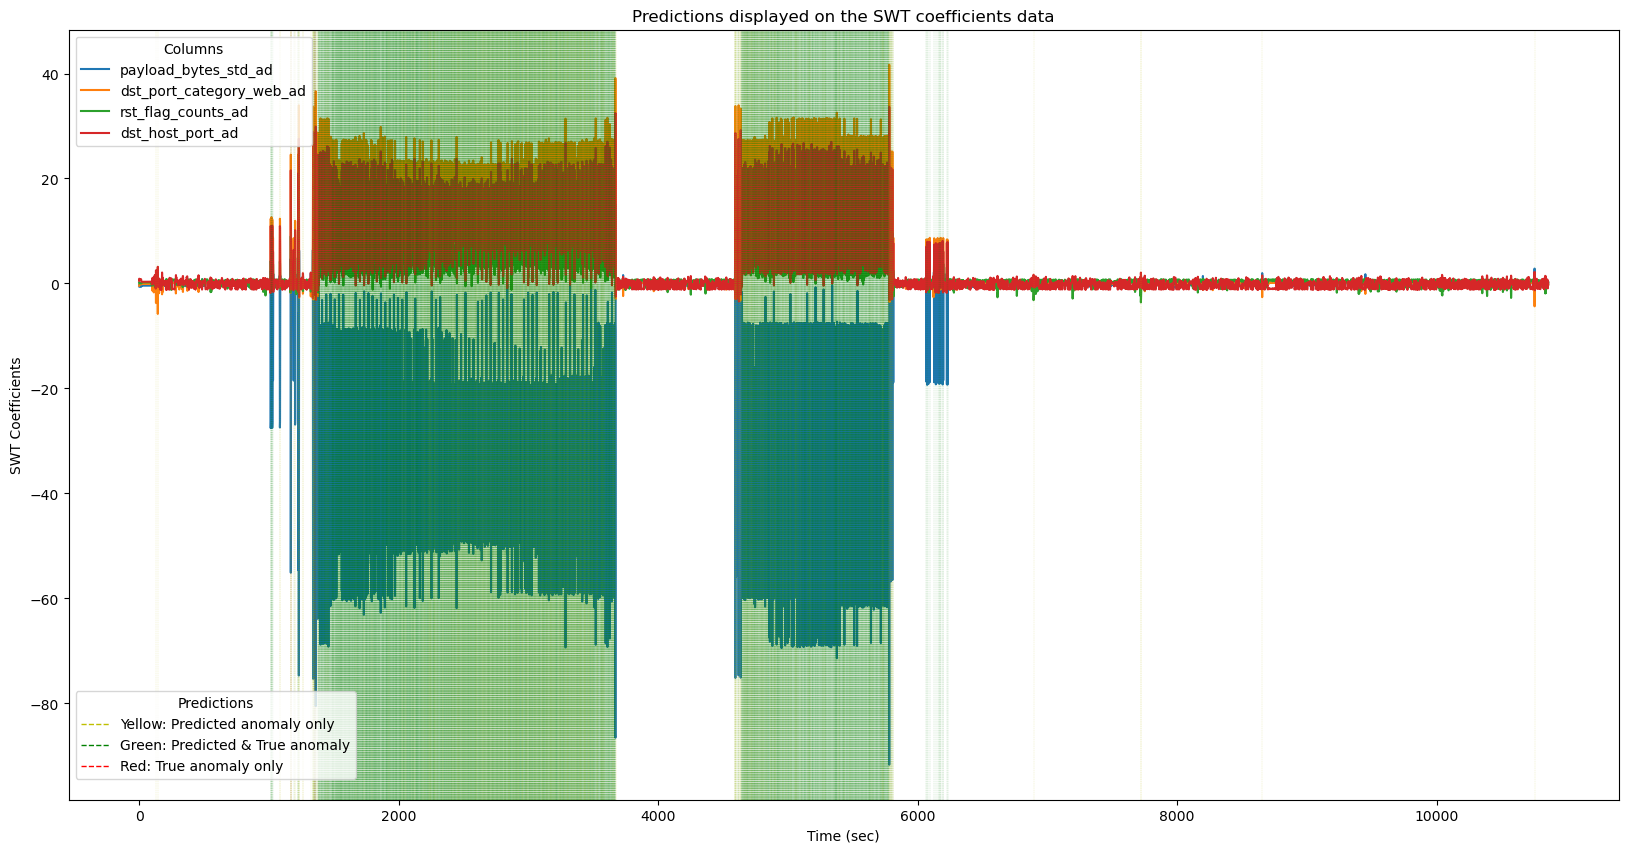

In [1008]:
plot_predictions(y_true, y_pred, X_thursday_swt)